# **Distance Predictor Part 5**
Author: Declan Costello

Date: 8/19/2023

## **Part 5 Description**

Here I Create pipelines with hyperparameter tuning Imputation, Scalling, One Hot encoding, and then use grid search for hyper parameter tuning utilizing the new features created in part 3

## **Table of Context**

1. [Installation](#Installation)
2. Data Import
3. Preprocessing
4. Piplelines
5. Train Test Split
6. Stratify
7. Residuals
8. Confusion Matrix
9. Permutaion Importance
10. Partial Dependence Plot
11. TODO [add partial dependence variance](https://docs.seldon.io/projects/alibi/en/stable/overview/high_level.html#path-dependent-tree-shap)
12. [Final Pipeline](#final-pipeline)
13. [Results](#Results)

**Installation**
- The following installs the necessary packages

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import random
# import numpy as np
# from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [3]:
import joblib
import bz2

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import numpy as np
from scipy.integrate import simps

In [6]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import row
from bokeh.layouts import gridplot
output_notebook()

Loading BokehJS ...

**Data Import**

In [7]:
data = pd.read_csv('FE_data.csv')

**Preprocessing**

In [8]:
numeric_features = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])


categorical_features = ["home_team","stand","p_throws",'grouped_pitch_type','fav_platoon_split_for_batter']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, numeric_features),
    ("cat_transform", categorical_transformer, categorical_features)
])

**Pipelines**

In [9]:
XGBRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("Random Forest Regressor", XGBRegressor(XGB__learning_rate=0.1, max_depth=5, min_child_weight = 1, subsample = 1.0, n_estimators=10))])

RandomForestRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("rf", RandomForestRegressor())])
# add a tree viz
'''
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

https://www.kaggle.com/code/dansbecker/partial-plots/tutorial

from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(ter, out_file=None, feature_names=feature_cols)
graphviz.Source(tree_graph)
'''

MLPRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("MLPR", MLPRegressor())])

GradientBoostingRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("gbr", GradientBoostingRegressor())])

**Train Test Split**

In [10]:
feature_cols = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed","home_team","stand","p_throws","fav_platoon_split_for_batter","grouped_pitch_type", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

**[Stratify](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**
- [I can only stratify three features because only working with ~100k rows](https://github.com/davidsbatista/text-classification/issues/1)
- [Eventual StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=0,stratify = X[['home_team',"stand",'grouped_pitch_type']])

**VotingRegressor**
- Finally, we will visualize the predictions. The red stars show the average prediction made by VotingRegressor.

In [12]:
er = VotingRegressor([('ogxg', XGBRegressor_pipeline), ('MLPR', MLPRegressor_pipeline),('gbr',GradientBoostingRegressor_pipeline),('rf', RandomForestRegressor_pipeline)])
er.fit(X_train, y_train.values.ravel())

preds = er.predict(X_valid)

predicted_distance = list(preds)
actual_distance = y_valid['hit_distance_sc'].to_list()

[20:59:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


**Residuals**

In [13]:
predicted_distance = list(preds)
actual_distance = y_valid['hit_distance_sc'].to_list()

final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=500, width=500,title="Predicted vs Actual Distance")
p.circle(actual_distance, predicted_distance, size=5, line_color="skyblue", fill_color="skyblue", fill_alpha=0.3)
p.xaxis.axis_label = 'Actual Distance'
p.yaxis.axis_label = 'Predicted distance'

z = figure(height=500, width=500,title="Residual vs Predicted Distance")
z.circle(final_pipe_results.predicted_distance, final_pipe_results.residual, size=5, line_color="skyblue", fill_color="skyblue", fill_alpha=0.3)
z.xaxis.axis_label = 'Predicted Distance'
z.yaxis.axis_label = 'Residual (actual - predicted)'

b = figure(width=1000, height=500, toolbar_location=None,
           title="Normality of Residuals")

# Histogram
bins = np.linspace(-50, 50, 100)
hist, edges = np.histogram(final_pipe_results.residual, density=True, bins=bins)
b.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue", line_color="white")

b.y_range.start = 0
b.x_range.start = -20
b.x_range.end = 20

b.xaxis.axis_label = "Residuals"
b.yaxis.axis_label = "Distribution Count"

grid = gridplot([[row(p, z)], 
                 [b]])
show(grid)

**Confusion Matrix**

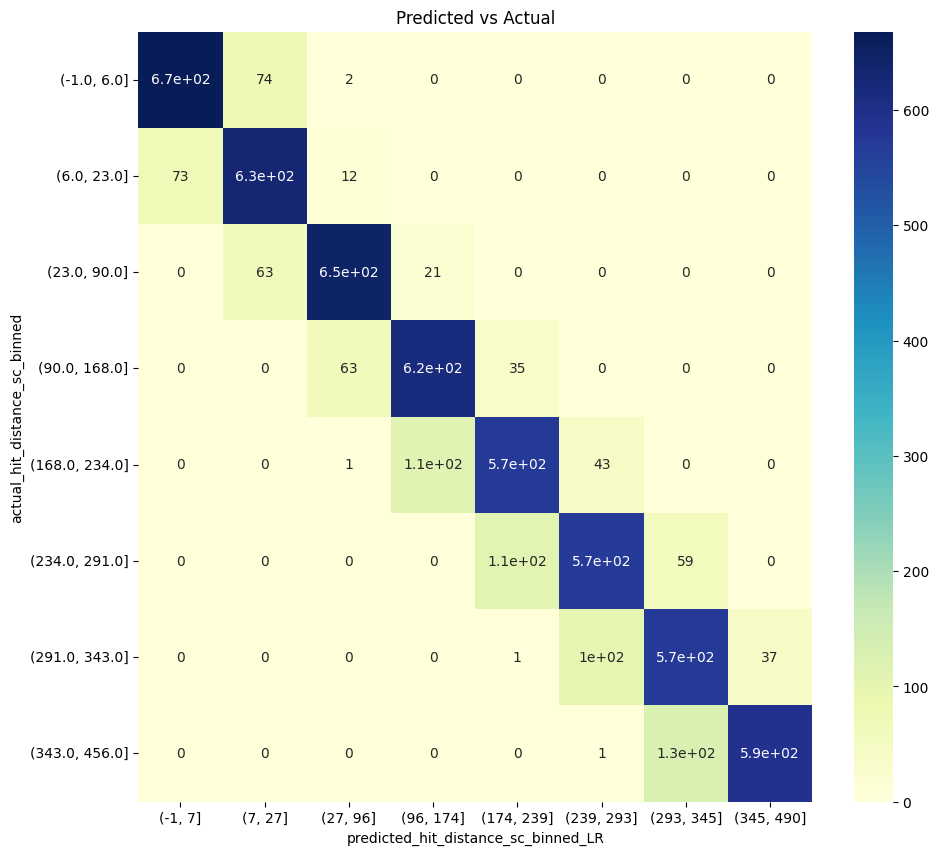

In [14]:
y_valid['actual_hit_distance_sc_binned'] = pd.qcut(y_valid['hit_distance_sc'], q=8, precision=0)
y_valid = y_valid.reset_index()
y_valid = y_valid.reset_index()
y_valid = y_valid.rename(columns={'level_0': 'key'})


df_predicted_LR = pd.DataFrame(predicted_distance, columns=['predicted_hit_distance_sc'])
bins = [-1, 7, 27, 96, 174, 239, 293, 345, 490]
df_predicted_LR['predicted_hit_distance_sc_binned_LR'] = pd.cut(df_predicted_LR['predicted_hit_distance_sc'], bins)
df_predicted__LR = df_predicted_LR.reset_index()
df_predicted__LR = df_predicted__LR.rename(columns={'index': 'key'})
result_2 = pd.merge(y_valid, df_predicted__LR, on="key")
result_2_heatmap = result_2.pivot_table(index='actual_hit_distance_sc_binned', columns='predicted_hit_distance_sc_binned_LR', aggfunc='count')


plt.figure(figsize=(50,10))
plt.subplot(141)
sns.heatmap(result_2_heatmap['hit_distance_sc'],cmap="YlGnBu",annot=True)
plt.title('Predicted vs Actual')
plt.show()


In [15]:
final_vars = X_valid.loc[X_valid['is_barrel']==1]
final_vars = final_vars.loc[final_vars['domed']==0]
f = final_vars.iloc[10]
final_vars = f.to_frame().T
final_vars['pfx_x'] = 0
final_vars

,launch_angle,launch_speed,pfx_x,pfx_z,release_speed,home_team,stand,p_throws,fav_platoon_split_for_batter,grouped_pitch_type,domed,spray_angle,is_barrel,Pop,pull_percent
90295,30.0,106.7,0,0.03,78.8,BOS,R,R,No,breaking,0,-15.025984,1,27.9,0.611255


# **[Permutaion Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)**
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

In [22]:
from sklearn.inspection import permutation_importance


ter = er.fit(X_train, y_train.values.ravel())

result = permutation_importance(ter, 
                                X_train, 
                                y_train.values.ravel(), 
                                n_repeats=10,
                                random_state=0)

fig, ax = plt.subplots(figsize=(7, 6))

perm_sorted_idx = result.importances_mean.argsort()

ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False
)
ax.axvline(x=0, color="k", linestyle="--")

[18:53:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [ ]:
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

ter = er.fit(X_train, y_train.values.ravel())

result = permutation_importance(ter, 
                                X_train, 
                                y_train.values.ravel(), 
                                n_repeats=10,
                                random_state=0)

# Sort importances
perm_sorted_idx = result.importances_mean.argsort()

# Create a figure and axis using Seaborn
plt.figure(figsize=(7, 6))
ax = sns.boxplot(data=result.importances[perm_sorted_idx].T, orient="h")

# Add a vertical line at 0
ax.axvline(x=0, color="k", linestyle="--")

plt.show()


# **Partial Dependence Plot**

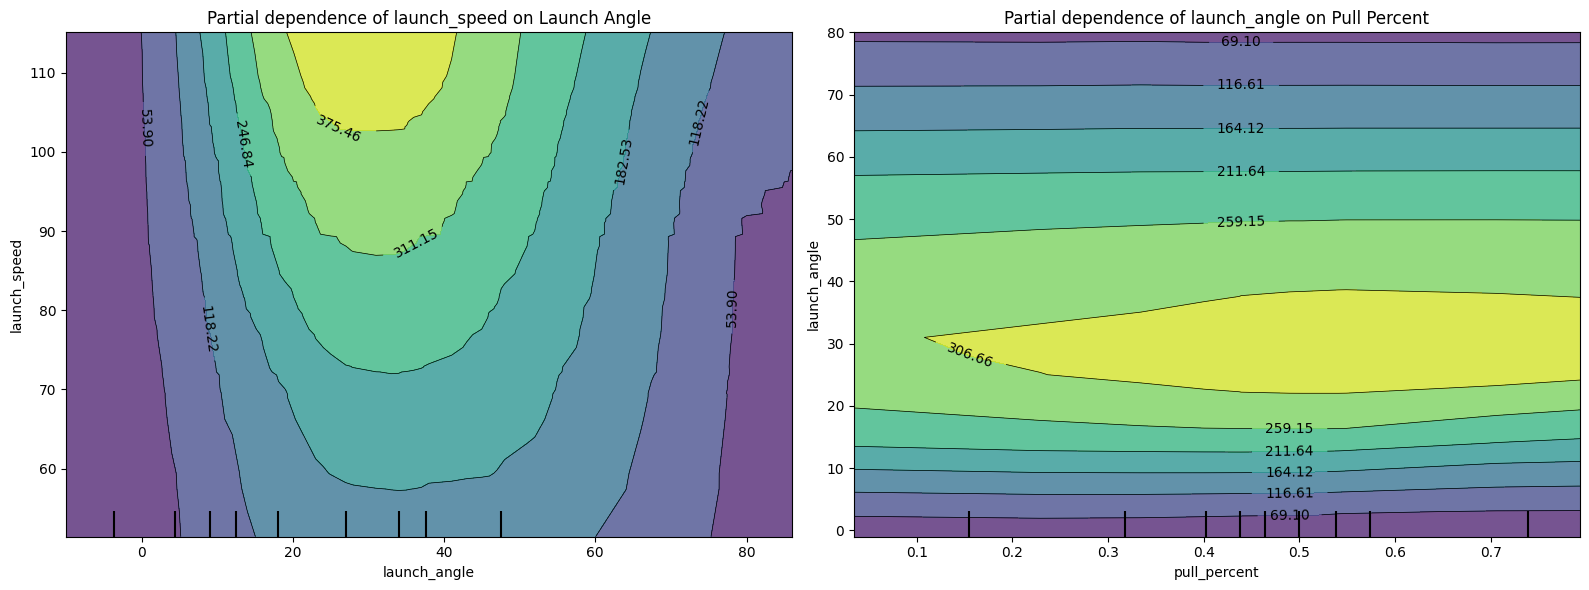

In [21]:
# Filter the data
X_train_filtered = X_train[X_train['launch_angle'].between(-10, 100)]

# Create two partial dependence plots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1
f_names = [('launch_angle', 'launch_speed')]
disp1 = PartialDependenceDisplay.from_estimator(ter, X_train_filtered[:90], f_names, ax=axs[0])
axs[0].set_xlim(-10, 100)
axs[0].set_title('Partial dependence of launch_speed on Launch Angle')

# Plot 2
f_names = [('pull_percent', 'launch_angle')]
disp2 = PartialDependenceDisplay.from_estimator(ter, X_train_filtered[:12], f_names, ax=axs[1])
axs[1].set_xlim(-10, 100)
axs[1].set_title('Partial dependence of launch_angle on Pull Percent')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


# **Saving Model**

In [ ]:
# # Compress the model using bz2 and save it with joblib
# with bz2.BZ2File('compressed_9_model.joblib.bz2', 'wb', compresslevel=9) as f:
#     joblib.dump(er, f)

# **Loading Model**

In [ ]:
# #load saved compressed model
# with bz2.BZ2File('compressed_9_model.joblib.bz2', 'rb') as f:
#     lo_mo = joblib.load(f)

# preds = lo_mo.predict(final_vars)
# preds[0]

In [ ]:
def plot_stadium_expected_distance(speed, team1, team2):
    # Define the launch angles
    list_of_launch_angles = [round(x * 0.1, 1) for x in range(0, 601)]
        
    final_vars['launch_speed'] = speed

    # Calculate distances for team1 and team2
    team1_distances = []
    team2_distances = []

    for i in list_of_launch_angles:
        final_vars['launch_angle'] = i
        final_vars['home_team'] = str(team1)
        preds = er.predict(final_vars)
        team1_distances.append(preds[0])

        final_vars['home_team'] = str(team2)
        preds = er.predict(final_vars)
        team2_distances.append(preds[0])

    # Calculate apex points for team1 and team2
    apex_x1 = list_of_launch_angles[np.argmax(team1_distances)]
    apex_y1 = max(team1_distances)

    apex_x2 = list_of_launch_angles[np.argmax(team2_distances)]
    apex_y2 = max(team2_distances)

    # Calculate the difference in max distances
    distance_difference = abs(apex_y1 - apex_y2)

    # Calculate the area between the curves using Simpson's rule (numerical integration)
    area_between_curves = simps(np.abs(np.array(team1_distances) - np.array(team2_distances)), list_of_launch_angles)

    # Generate random colors for team1 and team2
    team1_color = "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))
    team2_color = "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))

    # Create a Bokeh figure
    p = figure(width=1000, height=500, title=f'{speed} MPH Exit Velocity', x_axis_label='Launch Angle (degrees)', y_axis_label='Distance (feet)')

    # Plot the lines for team1 and team2 with random colors
    p.line(list_of_launch_angles, team1_distances, line_width=2, color=team1_color)
    p.line(list_of_launch_angles, team2_distances, line_width=2, color=team2_color)

    # Add vertical lines at the apex points with labels
    p.line([apex_x1, apex_x1], [0, apex_y1], line_width=2, color=team1_color, line_dash="dashed")
    p.line([apex_x2, apex_x2], [0, apex_y2], line_width=2, color=team2_color, line_dash="dashed")

    # Add labels to the apex points
    p.text(1, 375, text=[f'{str(team1)} Apex: ({apex_x1:.1f}, {apex_y1:.1f} ft)'], text_font_size="12pt", text_color=team1_color)
    p.text(1, 360, text=[f'{str(team2)} Apex: ({apex_x2:.1f}, {apex_y2:.1f} ft)'], text_font_size="12pt", text_color=team2_color)
    p.text(1, 345, text=[f'Max Distance Difference: {distance_difference:.2f} ft'], text_font_size="12pt", text_color=team1_color)
    p.text(1, 330, text=[f'Area Between Curves: {area_between_curves:.2f} ft'], text_font_size="12pt", text_color=team2_color)


    # Fill the area between the curves
    p.varea(x=list_of_launch_angles, y1=team1_distances, y2=team2_distances, color='gray', alpha=0.3)

    # Show the plot with legend
    p.x_range.start = 0
    p.x_range.end = 60
    p.y_range.start = 0

    show(p)

# **Model Use Case #1**

In [ ]:
plot_stadium_expected_distance(97, 'COL', 'CHC')

In [ ]:
def max_las_for_each_ev(team1, team2):

    results_df = pd.DataFrame(columns=['Stadium','EV','LA','Distance'])
    count = 0
    final_vars['home_team'] = str(team1)
    for i in range(80,110):

        final_vars['launch_speed'] = i


        # Define the launch angles
        list_of_launch_angles = [round(x * 0.1, 1) for x in range(0, 601)]

        # Calculate distances for team1 and team2
        team1_distances = []

        for x in list_of_launch_angles:
            final_vars['launch_angle'] = x
            preds = er.predict(final_vars)
            team1_distances.append(preds[0])

        # Calculate apex points for team1 and team2
        apex_x1 = list_of_launch_angles[np.argmax(team1_distances)]
        apex_y1 = max(team1_distances)

        #print('for an EV of ' + str(i) + ', the best LA is ' + str(apex_x1) + ' for a distance of ' + str(apex_y1))
        results_df.loc[count] = [str(team1),i,apex_x1,apex_y1]
        count = count +1  


    final_vars['home_team'] = str(team2)
    team1_distances = []
    for i in range(80,110):

        final_vars['launch_speed'] = i

        # Define the launch angles
        list_of_launch_angles = [round(x * 0.1, 1) for x in range(0, 601)]

        # Calculate distances for team1 and team2
        team1_distances = []

        for x in list_of_launch_angles:
            final_vars['launch_angle'] = x
            preds = er.predict(final_vars)
            team1_distances.append(preds[0])

        # Calculate apex points for team1 and team2
        apex_x1 = list_of_launch_angles[np.argmax(team1_distances)]
        apex_y1 = max(team1_distances)

        #print('for an EV of ' + str(i) + ', the best LA is ' + str(apex_x1) + ' for a distance of ' + str(apex_y1))
        results_df.loc[count] = [str(team2),i,apex_x1,apex_y1]
        count = count +1

    return results_df

# **Model Use Case #2**

In [ ]:
l = max_las_for_each_ev('CHC', 'COL')

results_df = l.sort_values('Distance', ascending=False)

def color_recommend(value):
    if value == 'COL':
        color = 'skyblue'
    elif value == 'CHC':
        color = 'lightgreen'
    else:
        return
    return f'background-color: {color}'


(
    results_df.style.applymap(color_recommend, subset=['Stadium'])\
                .format({"EV": "{:20,.0f}"},
                        #fix l deci,aks
                        {"LA":'{}'})\
                .hide_index()\
                .background_gradient(cmap='Blues')
)

/var/folders/vc/prq7ffv51gl630xh6bmjgj700000gp/T/ipykernel_98927/3106350175.py:16: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  .hide_index()\


Stadium,EV,LA,Distance
COL,109,27.500000,436.060345
COL,108,27.900000,435.118497
COL,107,28.200000,431.756401
COL,106,27.500000,429.448395
COL,105,28.900000,427.132013
CHC,109,27.600000,422.084850
CHC,108,27.600000,420.687757
COL,104,29.200000,420.579777
COL,103,29.500000,418.725144
CHC,107,27.600000,417.825125


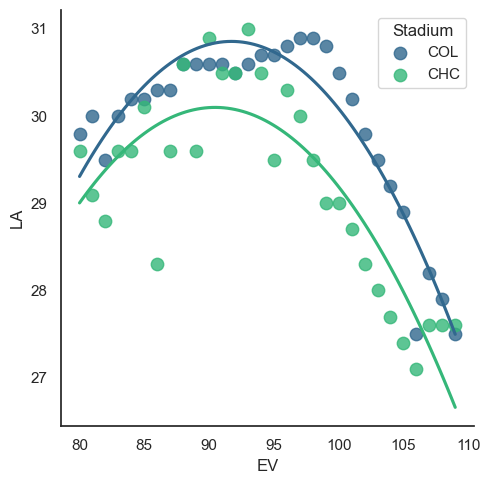

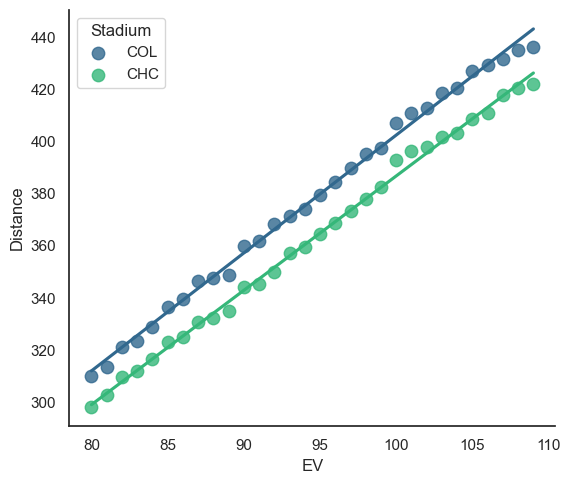

In [ ]:
# Create a figure with two subplots side by side

# First lmplot
ax = sns.lmplot(data=results_df, 
           x="EV", 
           y="LA",  
           hue="Stadium", 
           order=2,
           ci=None,
           palette='viridis',
           scatter_kws={"s": 80})
ax.legend.remove()


plt.legend(title = "Stadium",loc = 'upper right')


# Second lmplot
ax2 = sns.lmplot(data=results_df, 
           x="EV", 
           y="Distance",  
           hue="Stadium", 
           order=1,
           ci=None,
           palette='viridis',
           scatter_kws={"s": 80})
ax2.legend.remove()


plt.legend(title = "Stadium",loc = 'upper left')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
